The first step is to generate an initial particle configuration. Given the particle number $N$, the function generate_initial_configuration(N) returns the initial coordinates of the particles.

In [2]:
import numpy as np
from numba import njit

@njit
def generate_initial_configuration(N):
    # Generate N cities randomly in a 1x1 square box
    initial_coordinates = np.random.rand(N, 2)  # Each city is represented by its (x, y) coordinates
    return initial_coordinates

Then we define the Lennard-Jones potential. Given the parameter $\sigma$, the coordinates of particles, and the particle index $i$ and $j$, the function LJ_potential(sigma, coordinates, i, j) returns the interaction energy between the two particles divided by $\epsilon$.

In [4]:
@njit
def LJ_potential(sigma, coordinates, i, j):
    distance = np.sqrt(np.sum((coordinates[i] - coordinates[j]) ** 2))  # Calculate Euclidean distance
    
    # Find the shortest distance under periodic boundary condition
    periodic_displacement = np.array([[1, 0], [-1, 0], [0, 1], [0, -1], [1, 1], [1, -1], [-1, 1], [-1, -1]])
    for k in range(8):
        new_distance = np.sqrt(np.sum((coordinates[i] + periodic_displacement[k] - coordinates[j]) ** 2))
        if new_distance < distance:
            distance = new_distance
    
    r = distance / sigma  # Calculate the renormalized distance
    V_LJ = 4 * ( r ** (- 12) - r ** (- 6))  # Calculate the interaction energy
    return V_LJ

Next, we try moving one particle with a random displacement. Given the current particle configuration, the steplength, and the particle index, the function trial_move(coordinates, step_length, i) returns a trial configuration with particle $i$ moved.

In [6]:
@njit
def trial_move(coordinates, step_length, i):
    trial_coordinates = coordinates.copy()
    displacement_x = step_length * np.random.rand()  # Displacement in the x direction
    displacement_y = step_length * np.random.rand()  # Displacement in the y direction
    trial_coordinates[i][0] += displacement_x
    trial_coordinates[i][0] %= 1
    trial_coordinates[i][1] += displacement_y
    trial_coordinates[i][1] %= 1
    return trial_coordinates

The next step is to calculate the energy difference and decide whether or not to accept the move. With the particle number, the parameter $\sigma$, the current particle configuration, the trial particle configuration, the index of the moved particle, the function energy_change(N, coordinates, trial_coordinates, i, T) returns the energy change after the trial move. Given the energy change and the temperature $T$, the function accept_move(Delta_E, T) returns True or False as the decision to accept the move.

In [8]:
@njit
def energy_change(N, sigma, coordinates, trial_coordinates, i):
    # Calculate the energy change
    Delta_E = 0
    for j in range(i):
        Delta_E += LJ_potential(sigma, trial_coordinates, i, j)
        Delta_E -= LJ_potential(sigma, coordinates, i, j)
    for j in range(i + 1, N):
        Delta_E += LJ_potential(sigma, trial_coordinates, i, j)
        Delta_E -= LJ_potential(sigma, coordinates, i, j)
    
    return Delta_E

In [9]:
@njit
def accept_move(Delta_E, T):
    
    # If Delta_E is negative, always accept the move
    if Delta_E < 0:
        return True
    
    # If E is positive, accept the move with probability e^{-E/T}
    if np.exp(- Delta_E / T) > np.random.rand():  # Using NumPy's random number generator for speed and efficiency
        return True
    else:
        return False

Then, we need to define the temperature. Given the initial temperature in terms of $\epsilon$, the cooling rate, the iteration number, and the function temperature(initial_temperature, cooling_rate, iteration) returns the current temperature.

In [11]:
@njit
def temperature(initial_temperature, cooling_rate, iteration):
    # Determine the current step's temperature decrement
    temperature_decrement = cooling_rate * initial_temperature  # Decrease by cooling rate times initial temperature
    
    # Calculate the current temperature based on the step number and decrement
    current_temperature = initial_temperature - iteration * temperature_decrement
    
    # Ensure the temperature doesn't fall below a minimum threshold (e.g., a small positive value)
    current_temperature = max(current_temperature, 0.001 * temperature_decrement)  # Adjust this minimum threshold as needed
    
    return current_temperature

Now we are ready to search for the ground state configuration. Given the system size, the interaction parameter $\sigma$, the step length, the initial temperature, and the cooling rate, the function find_GS(N, sigma, step_length, initial_temperature, cooling_rate) returns the ground state particle configuration.

In [13]:
@njit
def find_GS(N, sigma, step_length, initial_temperature, cooling_rate):
    coordinates = generate_initial_configuration(N)  # Initial configuration
    moving = True  # Not yet converged
    iteration = 0  # Iteration number
    E = 0
    energy = []
    
    # Let it approach equilibrium
    T = initial_temperature
    for k in range(N):
        for i in range(N):
            trial_coordinates = trial_move(coordinates, 20 * step_length, i)
            Delta_E = energy_change(N, sigma, coordinates, trial_coordinates, i)
            if accept_move(Delta_E, T):
                coordinates = trial_coordinates.copy()
    for k in range(N):
        for i in range(N):
            trial_coordinates = trial_move(coordinates, 4 * step_length, i)
            Delta_E = energy_change(N, sigma, coordinates, trial_coordinates, i)
            if accept_move(Delta_E, T):
                coordinates = trial_coordinates.copy()

    # Cool it down
    while moving:
        moving = False
        T = temperature(initial_temperature, cooling_rate, iteration)
        for k in range(2):
            for i in range(N):
                trial_coordinates = trial_move(coordinates, step_length, i)
                Delta_E = energy_change(N, sigma, coordinates, trial_coordinates, i)
                if accept_move(Delta_E, T):
                    coordinates = trial_coordinates.copy()
                    E += Delta_E
                    moving = True
                energy.append(E)
        iteration += 1
    
    return coordinates, energy

We would like to plot the ground state configuration.

In [15]:
import matplotlib.pyplot as plt

def plot_GS(coordinates, N, sigma):
    # Create the plot
    plt.figure(figsize=(6, 6))  # Set the figure size to visualize the square region
    plt.axis("equal")  # Equal aspect ratio
    plt.xlim(0, 1)  # Set the limits of the x-axis to match the square region
    plt.ylim(0, 1)  # Set the limits of the y-axis to match the square region
    plt.scatter(coordinates[:, 0], coordinates[:, 1])

    plt.title(f'Ground State Configuration with {N} particles, sigma = {sigma:.2f}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.tick_params(direction='in')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

We can give it a try.

elapsed time =  396.4139018058777


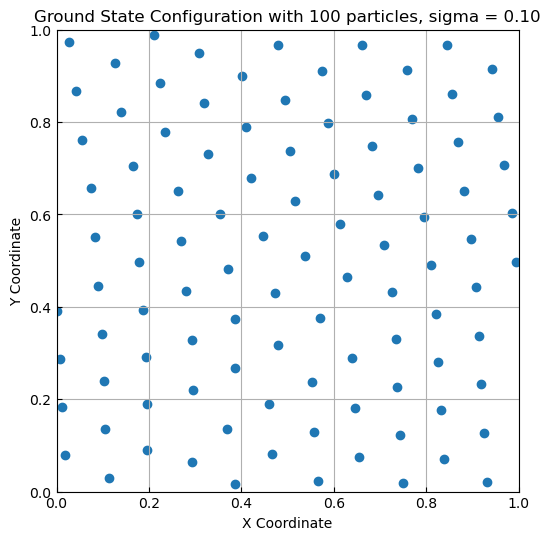

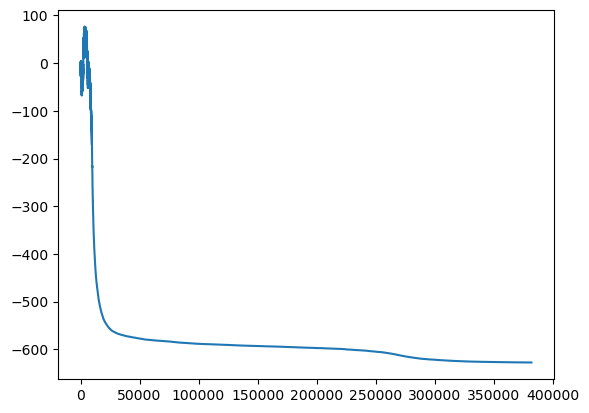

In [17]:
import time

N = 100
sigma = (2 ** (1 / 3)) * (3 ** (- 1 / 4)) * (N ** ( - 0.5))
step_length = 0.02 * sigma
initial_temperature = 30
cooling_rate = 0.02

time1 = time.time()
coordinates, energy = find_GS(N, sigma, step_length, initial_temperature, cooling_rate)
time2 = time.time()

print("elapsed time = ", time2 - time1)
    
plot_GS(coordinates, N, sigma)
plt.plot(energy)